In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

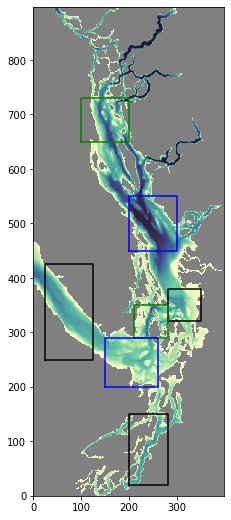

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'g')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'b')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'k')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'k')
SS_all = [0, 898, 0, 398]
boxes = [SS_all, SoG_south,SoG_center, SoG_north, PS_main, Haro_Boundary, JdF_west, JdF_east]
boxnames = ['SS_all', 'SoG_south', 'SoG_center', 'SoG_north', 'PS_main', 'Haro_Boundary',
           'JdF_west', 'JdF_east']

In [5]:
years = ['2007', '2008']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [6]:
print (deptht[20])

<xarray.DataArray 'gdept_1d' ()>
array(24.100257)


In [7]:
def extract_phys(years, months, tdir, times_recon, temp_recon, dsal_recon):
    index = 0
    for year in years:
        for month in months:
            times_recon[index] = np.datetime64(f'{year}-{month}-15')
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_grid_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                grid_T = xr.open_dataset(filename)
                temp_recon[index] = np.ma.array(grid_T.votemper.isel(deptht=slice(0, 6), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, 6), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                dsal_recon[index] = (np.ma.array(grid_T.vosaline.isel(deptht=10, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=10, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                      - np.ma.array(grid_T.vosaline.isel(deptht=0, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=10, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean())
                grid_T.close()
            index = index + 1
    return times_recon, temp_recon, dsal_recon

In [8]:
def extract_par(years, months, tdir, par_recon):
    index = 0
    for year in years:
        for month in months:
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_carp_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                carp_T = xr.open_dataset(filename)
                par_recon[index] = np.ma.array(carp_T.PAR.isel(deptht=0, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=0, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                carp_T.close()
            index = index + 1
    return par_recon

In [9]:
def extract_bio(years, months, tdir, diat_recon, flag_recon, nitrate_recon):
    dmax = 20
    imax = 19
    index = 0
    for year in years:
        for month in months:
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_ptrc_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                ptrc_T = xr.open_dataset(filename)
                diat_recon[index] = np.ma.array(ptrc_T.diatoms.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                flag_recon[index] = np.ma.array(ptrc_T.flagellates.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                nitrate_recon[index] = np.ma.array(ptrc_T.nitrate.sel(deptht=slice(0, 3)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, 3), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                ptrc_T.close()
            index = index + 1
    return diat_recon, flag_recon, nitrate_recon
        

In [10]:
def extract_zoo(years, months, tdir, meso_recon, micro_recon):
    dmax = 20
    imax = 19
    index = 0
    for year in years:
        for month in months:
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_ptrc_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                ptrc_T = xr.open_dataset(filename)
                meso_recon[index] = np.ma.array(ptrc_T.mesozooplankton.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                micro_recon[index] = np.ma.array(ptrc_T.microzooplankton.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                ptrc_T.close()
            index = index + 1
    return meso_recon, micro_recon
        

In [11]:
noy = 2
times_recon = np.zeros(noy*12).astype('datetime64[s]')
temp_recon = np.zeros(noy*12)
dsal_recon = np.zeros_like(temp_recon)
diat_recon = np.zeros_like(temp_recon)
flag_recon = np.zeros_like(temp_recon)
nitrate_recon = np.zeros_like(temp_recon)
meso_recon = np.zeros_like(temp_recon)
micro_recon = np.zeros_like(temp_recon)
par_recon = np.zeros_like(temp_recon)
times_recon, temp_recon, dsal_recon = extract_phys(years, months, 'recon_datetime', times_recon, temp_recon, dsal_recon)
diat_recon, flag_recon, nitrate_recon = extract_bio(years, months, 'recon_datetime', diat_recon, flag_recon, nitrate_recon)
meso_recon, micro_recon = extract_zoo(years, months, 'recon_datetime', meso_recon, micro_recon)
par_recon = extract_par(years, months, 'recon_datetime', par_recon)

/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_da

In [12]:
times_base = np.zeros(noy*12).astype('datetime64[s]')
temp_base = np.zeros(noy*12)
dsal_base = np.zeros_like(temp_base)
diat_base = np.zeros_like(temp_base)
flag_base = np.zeros_like(temp_base)
nitrate_base = np.zeros_like(temp_base)
meso_base = np.zeros_like(temp_base)
micro_base = np.zeros_like(temp_base)
par_base = np.zeros_like(temp_base)
times_base, temp_base, dsal_base = extract_phys(years, months, 'base_32/*/', times_base, temp_base, dsal_base)
diat_base, flag_base, nitrate_base = extract_bio(years, months, 'base_32/*/', diat_base, flag_base, nitrate_base)
meso_base, micro_base = extract_zoo(years, months, 'base_32/*/', meso_base, micro_base)
par_base = extract_par(years, months, 'base_32/*/', par_base)

/data/sallen/results/MEOPAR/202111/base_32/01jan07/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01feb07/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01feb07/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/23mar07/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01may07/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01may07/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01jul07/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01jul07/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01sep07/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01sep07/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01nov07/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/2021

In [42]:
noy = 2
times_opt = np.zeros(noy*12).astype('datetime64[s]')
temp_opt = np.zeros(noy*12)
dsal_opt = np.zeros_like(temp_opt)
diat_opt = np.zeros_like(temp_opt)
flag_opt = np.zeros_like(temp_opt)
nitrate_opt = np.zeros_like(temp_opt)
meso_opt = np.zeros_like(temp_opt)
micro_opt = np.zeros_like(temp_opt)
par_opt = np.zeros_like(temp_opt)
times_opt, temp_opt, dsal_opt = extract_phys(years, months, 'base_opt', times_opt, temp_opt, dsal_opt)
diat_opt, flag_opt, nitrate_opt = extract_bio(years, months, 'base_opt', diat_opt, flag_opt, nitrate_opt)
meso_opt, micro_opt = extract_zoo(years, months, 'base_opt', meso_opt, micro_opt)
par_opt = extract_par(years, months, 'base_opt', par_opt)

/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200702_200702_grid_T.nc
No file for 2007 03
No file for 2007 04
No file for 2007 05
No file for 2007 06
No file for 2007 07
No file for 2007 08
No file for 2007 09
No file for 2007 10
No file for 2007 11
No file for 2007 12
No file for 2008 01
No file for 2008 02
No file for 2008 03
No file for 2008 04
No file for 2008 05
No file for 2008 06
No file for 2008 07
No file for 2008 08
No file for 2008 09
No file for 2008 10
No file for 2008 11
No file for 2008 12
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200701_200701_ptrc_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200702_200702_ptrc_T.nc
No file for 2007 03
No file for 2007 04
No file for 2007 05
No file for 2007 06
No file for 2007 07
No file for 2007 08
No file for 2007 09
No file for 2007 10
No file for 2007 11
No file for 2007 12
No file for 2008 01
No file for 2008

In [14]:
noy = 2
times_3havg = np.zeros(noy*12).astype('datetime64[s]')
temp_3havg = np.zeros(noy*12)
dsal_3havg = np.zeros_like(temp_3havg)
diat_3havg = np.zeros_like(temp_3havg)
flag_3havg = np.zeros_like(temp_3havg)
nitrate_3havg = np.zeros_like(temp_3havg)
meso_3havg = np.zeros_like(temp_3havg)
micro_3havg = np.zeros_like(temp_3havg)
par_3havg = np.zeros_like(temp_3havg)
times_3havg, temp_3havg, dsal_3havg = extract_phys(years, months, '3havg', times_3havg, 
                                                   temp_3havg, dsal_3havg)
diat_3havg, flag_3havg, nitrate_3havg = extract_bio(years, months, '3havg', diat_3havg, 
                                                    flag_3havg, nitrate_3havg)
meso_3havg, micro_3havg = extract_zoo(years, months, '3havg', meso_3havg, micro_3havg)
par_3havg = extract_par(years, months, '3havg', par_3havg)

/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_200708_200708_grid_T.nc
No file for 2007 09
No file for 2007 10
No file for 2007 11
No file for 2007 12
No file for 2008 01
No file for 2008 02
No file for 2008 03
No file for 2008 04
No file for 2008 05
No file for 2008 06
No file for 2008 07
No file for 2008 08
No file for 2008 09
No file for 2008 10
No file for 2008 11
No file for 2008 12
/data/sallen/results/MEOPAR/202111/3havg/SalishSea_1m_20

In [15]:
noy = 2
times_mixed = np.zeros(noy*12).astype('datetime64[s]')
temp_mixed = np.zeros(noy*12)
dsal_mixed = np.zeros_like(temp_mixed)
diat_mixed = np.zeros_like(temp_mixed)
flag_mixed = np.zeros_like(temp_mixed)
nitrate_mixed = np.zeros_like(temp_mixed)
meso_mixed = np.zeros_like(temp_mixed)
micro_mixed = np.zeros_like(temp_mixed)
par_mixed = np.zeros_like(temp_mixed)
times_mixed, temp_mixed, dsal_mixed = extract_phys(years, months, 'mixed_forcing', times_mixed, 
                                                   temp_mixed, dsal_mixed)
diat_mixed, flag_mixed, nitrate_mixed = extract_bio(years, months, 'mixed_forcing', diat_mixed, 
                                                    flag_mixed, nitrate_mixed)
meso_mixed, micro_mixed = extract_zoo(years, months, 'mixed_forcing', meso_mixed, micro_mixed)
par_mixed = extract_par(years, months, 'mixed_forcing', par_mixed)

/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200705_200705_grid_T.nc
No file for 2007 06
No file for 2007 07
No file for 2007 08
No file for 2007 09
No file for 2007 10
No file for 2007 11
No file for 2007 12
No file for 2008 01
No file for 2008 02
No file for 2008 03
No file for 2008 04
No file for 2008 05
No file for 2008 06
No file for 2008 07
No file for 2008 08
No file for 2008 09
No file for 2008 10
No file for 2008 11
No file for 2008 12
/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200701_200701_ptrc_T.nc
/data/sallen/results/MEOPAR/202111/mixed_forcing/SalishSea_1m_200702_200702_ptrc_T.nc
/data/sallen/resul

In [16]:
noy = 2
times_reconX = np.zeros(noy*12).astype('datetime64[s]')
temp_reconX = np.zeros(noy*12)
dsal_reconX = np.zeros_like(temp_reconX)
diat_reconX = np.zeros_like(temp_reconX)
flag_reconX = np.zeros_like(temp_reconX)
nitrate_reconX = np.zeros_like(temp_reconX)
meso_reconX = np.zeros_like(temp_reconX)
micro_reconX = np.zeros_like(temp_reconX)
par_reconX = np.zeros_like(temp_reconX)
times_reconX, temp_reconX, dsal_reconX = extract_phys(years, months, 'reconX', times_reconX, temp_reconX, dsal_reconX)
diat_reconX, flag_reconX, nitrate_reconX = extract_bio(years, months, 'reconX', diat_reconX, flag_reconX, nitrate_reconX)
meso_reconX, micro_reconX = extract_zoo(years, months, 'reconX', meso_reconX, micro_reconX)
par_reconX = extract_par(years, months, 'reconX', par_reconX)

/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200712_200712_grid_T.nc
No file for 2008 01
No file for 2008 02
No file for 

In [17]:
years = ['2007', '2008']

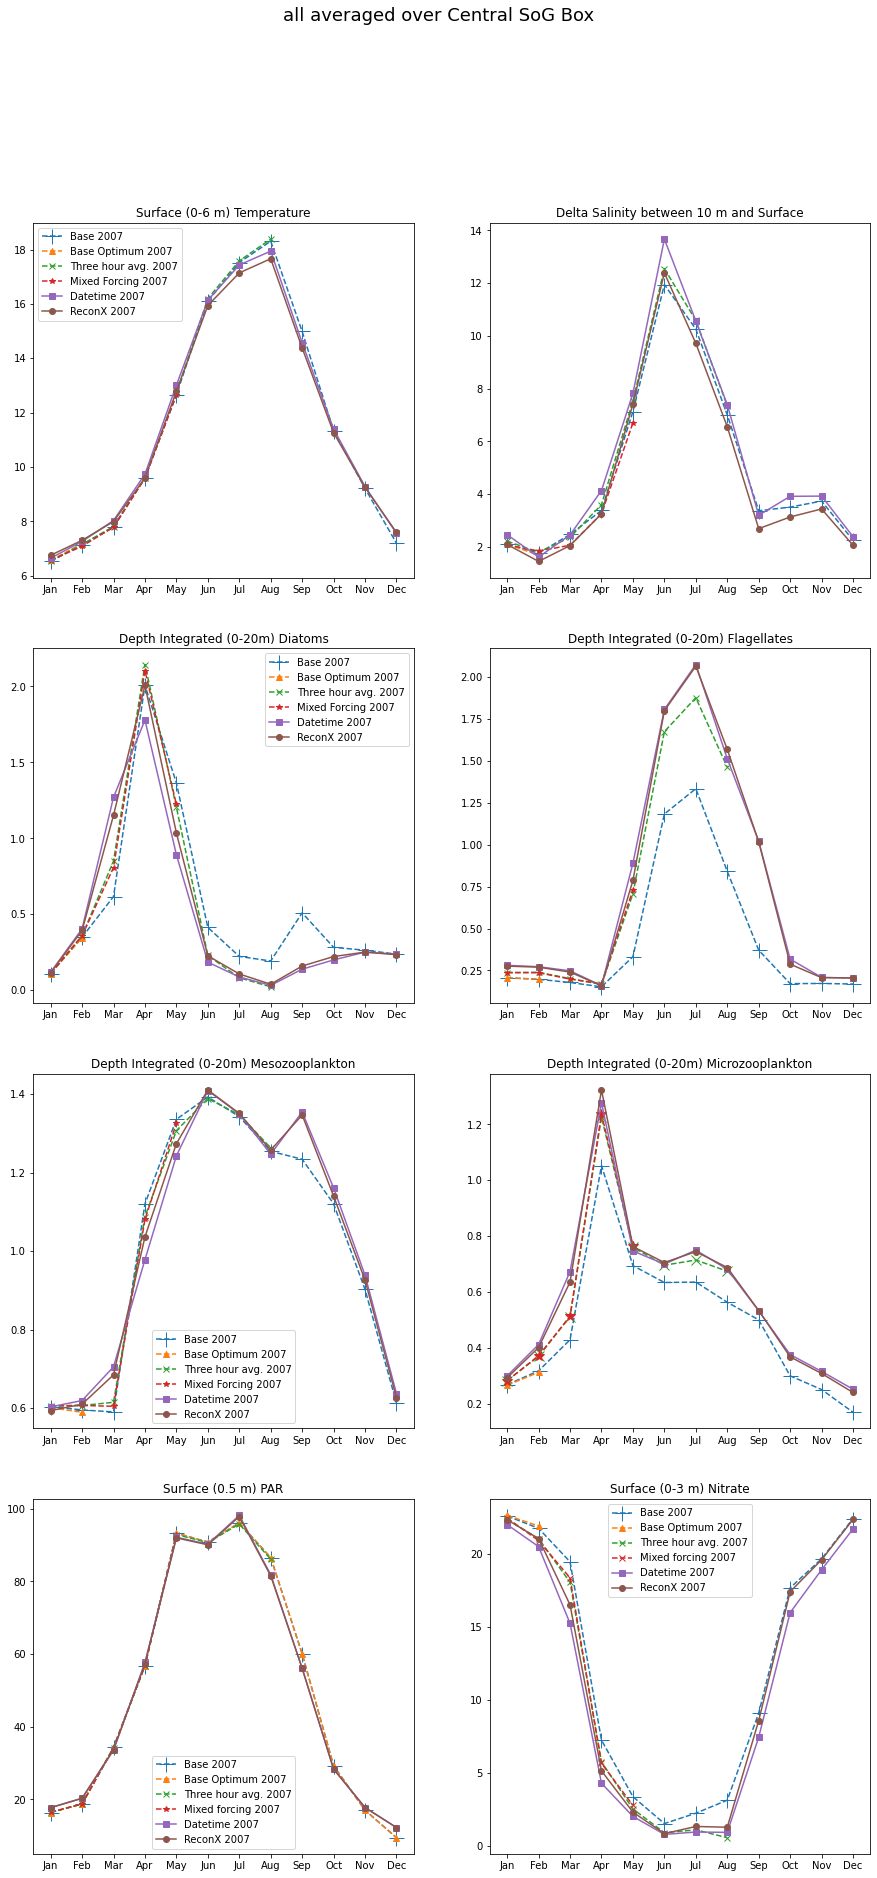

In [45]:
noy = 1
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
for iy in range(noy):
    lin, lup = iy*12, iy*12+12
    horz = [month_name[i%12] for i in range(lin, lup)]
    # Temperature
    vert = temp_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = temp_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}')
    vert = temp_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = temp_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = temp_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '-s', label=f'Datetime {years[iy]}')
    vert = temp_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '-o', label=f'ReconX {years[iy]}')
    # Stratification
    vert = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--+', markersize=15)
    vert = dsal_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--^')
    vert = dsal_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--x')
    vert = dsal_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--*')
    vert = dsal_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '-s');
    vert = dsal_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '-o');
    # Diatoms
    vert = diat_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = diat_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}')
    vert = diat_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = diat_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = diat_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '-s', label=f'Datetime {years[iy]}');
    vert = diat_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '-o', label=f'ReconX {years[iy]}');
    # Flagellates
    vert = flag_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--+', markersize=15)
    vert = flag_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--^')
    vert = flag_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--x')
    vert = flag_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--*')
    vert = flag_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '-s');
    vert = flag_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '-o');
    # Mesozooplankton
    vert = meso_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = meso_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}')
    vert = meso_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = meso_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = meso_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '-s', label=f'Datetime {years[iy]}');
    vert = meso_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '-o', label=f'ReconX {years[iy]}');
    # Microzooplankton
    vert = micro_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--+', markersize=15)
    vert = micro_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--^')
    vert = micro_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--x', markersize=10)
    vert = micro_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--*', markersize=10)
    vert = micro_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '-s');
    vert = micro_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '-o');
    # PAR
    vert = par_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = par_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}')
    vert = par_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = par_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--*', label=f'Mixed forcing {years[iy]}')
    vert = par_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '-s', label=f'Datetime {years[iy]}');
    vert = par_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '-o', label=f'ReconX {years[iy]}');
    # Nitrate
    vert = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = nitrate_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}')
    vert = nitrate_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = nitrate_mixed[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--x', label=f'Mixed forcing {years[iy]}')
    vert = nitrate_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '-s', label=f'Datetime {years[iy]}');
    vert = nitrate_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '-o', label=f'ReconX {years[iy]}');
#axs[3, 1].plot(times, np.cumsum(par_base), '--+')
#axs[3, 1].plot(times, np.cumsum(par_recon), '-x')
#axs[3, 1].plot(times, temp_recon/temp_base, '-s')
#ax2 = axs[3, 1].twinx()
#ax2.plot(times, np.cumsum(flag_base), 'g--+')
#ax2.plot(times, np.cumsum(flag_recon), 'r--+')
#ax2.plot(times, flag_recon/flag_base, '-or')
axs[0, 0].set_title('Surface (0-6 m) Temperature')
axs[0, 0].legend(loc='best')
axs[0, 1].set_title('Delta Salinity between 10 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='best')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 0].legend(loc='best')
axs[3, 1].set_title('Surface (0-3 m) Nitrate')
axs[3, 1].legend(loc='best')
fig.suptitle('all averaged over Central SoG Box', fontsize=18);

In [19]:
print (np.nanmean(temp_base[:12]), np.nanmean(temp_base[12:]))
print (np.nanmean(temp_recon[:12]), np.nanmean(temp_recon[12:]))
# agreed 2008 was colder
# recon is warmer

11.534040497308874 11.19285965189294
11.5850551039836 11.176433607480229


In [20]:
print (np.nanmean(dsal_base[:12]), np.nanmean(dsal_base[12:]))
print (np.nanmean(dsal_recon[:12]), np.nanmean(dsal_recon[12:]))
# agreed 2008 was less stratified
# recon is more stratified

4.910569118416366 3.860378301556031
5.295698481534661 4.542869619841057


In [ ]:
print (np.nanmean(diat_base[:12]), np.nanmean(diat_base[12:]))
print (np.nanmean(diat_recon[:12]), np.nanmean(diat_recon[12:]))
# agreed 2008 had more diatoms
# recon has less diatoms

In [21]:
print ('base, 2007', next((i, el) for i, el in enumerate(diat_base[:12]) if el > 1))
print ('base, 2008', next((i, el) for i, el in enumerate(diat_base[12:]) if el > 1))
print ('recon, 2007', next((i, el) for i, el in enumerate(diat_recon[:12]) if el > 1))
print ('recon, 2008', next((i, el) for i, el in enumerate(diat_recon[12:]) if el > 1))
# agreed 2008 early spring bloom
# recon spring bloom is earlier

base, 2007 (3, 2.0077760248207004)
base, 2008 (2, 1.2410699532414569)
recon, 2007 (2, 1.270187913092392)
recon, 2008 (2, 1.8176800247855436)


In [23]:
print (np.nanmean(flag_base[:12]), np.nanmean(flag_base[12:]))
print (np.nanmean(flag_recon[:12]), np.nanmean(flag_recon[12:]))
# agreed 2008 had more flagellates 
# recon has almost a factor of two more flagellates

0.4423450155074445 0.48639397876639184
0.7491321294601527 0.7640558371456487


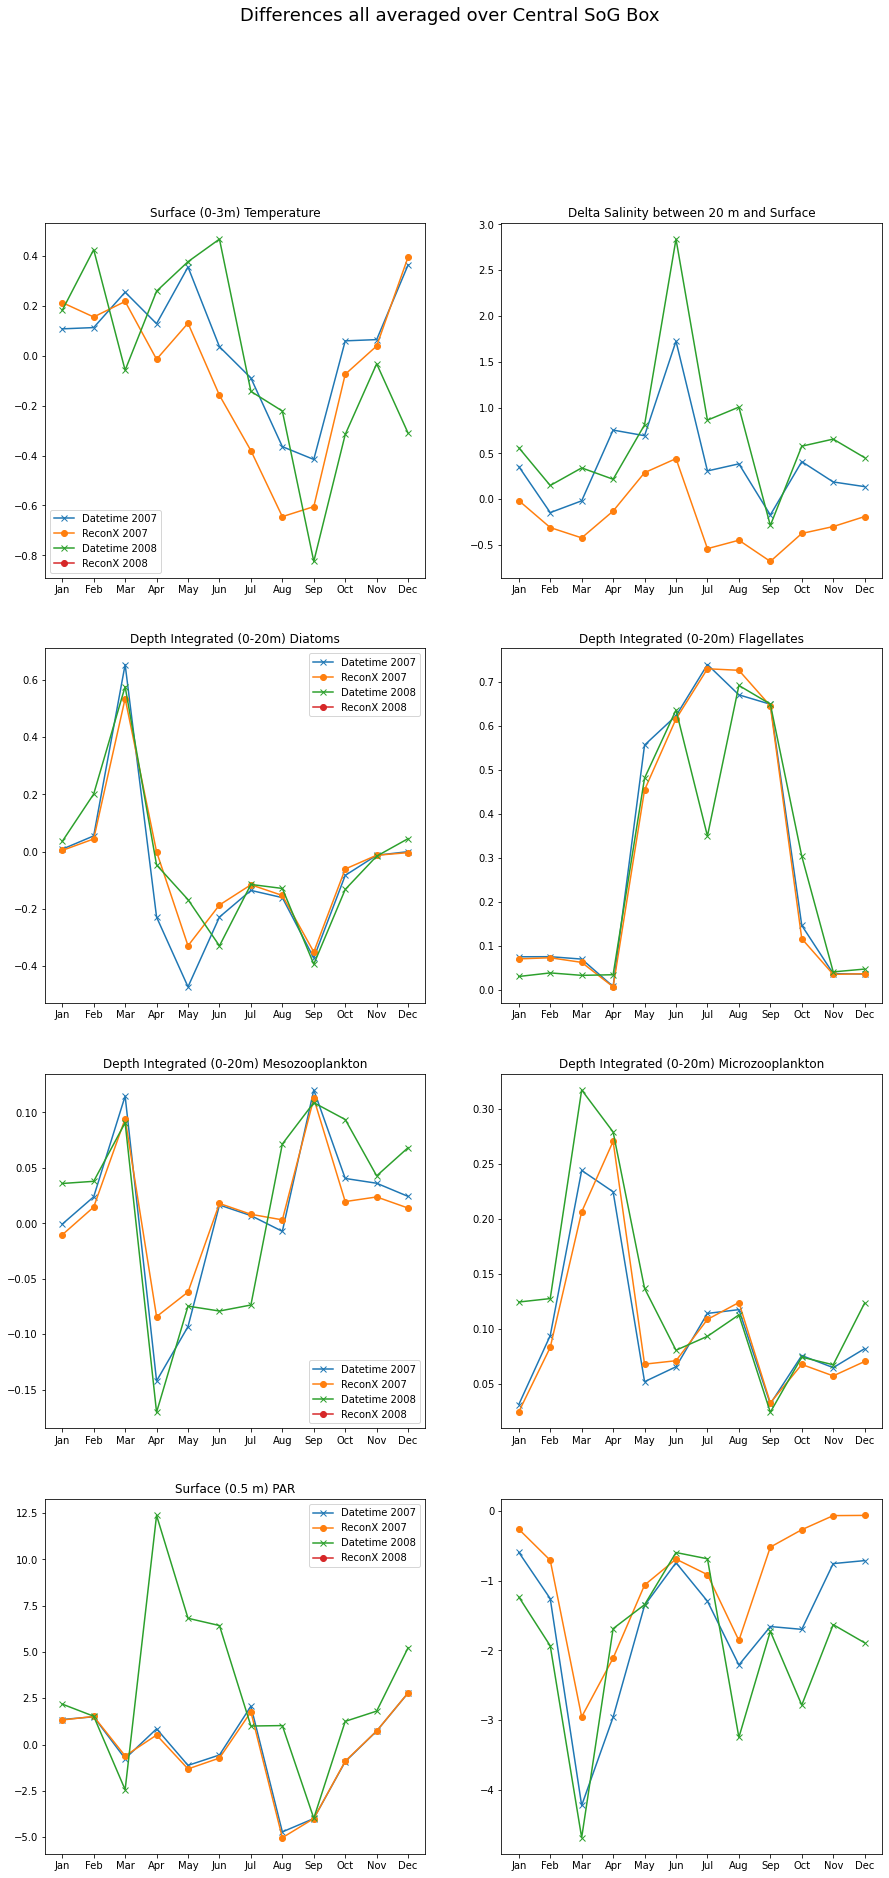

In [24]:
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
for iy in range(noy):
    lin, lup = iy*12, (iy+1)*12
    horz = [month_name[i%12] for i in range(lin, lup)]
    # Temperature
    vert1 = temp_base[lin:lup]; vert[vert == 0] = np.nan
    vert = temp_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}')
    vert = temp_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert-vert1, '-o', label=f'ReconX {years[iy]}')
    # Stratification
    vert1 = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    vert = dsal_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert-vert1, '-x');
    vert = dsal_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert-vert1, '-o');
    # Diatoms
    vert1 = diat_base[lin:lup]; vert[vert == 0] = np.nan
    vert = diat_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = diat_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert-vert1, '-o', label=f'ReconX {years[iy]}');
    # Flagellates
    vert1 = flag_base[lin:lup]; vert[vert == 0] = np.nan
    vert = flag_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert-vert1, '-x');
    vert = flag_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert-vert1, '-o');
    # Mesozooplankton
    vert1 = meso_base[lin:lup]; vert[vert == 0] = np.nan
    vert = meso_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = meso_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert-vert1, '-o', label=f'ReconX {years[iy]}');
    # Microzooplankton
    vert1 = micro_base[lin:lup]; vert[vert == 0] = np.nan
    vert = micro_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert-vert1, '-x');
    vert = micro_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert-vert1, '-o');
    # PAR
    vert1 = par_base[lin:lup]; vert[vert == 0] = np.nan
    vert = par_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = par_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert-vert1, '-o', label=f'ReconX {years[iy]}');
    # Nitrate
    vert1 = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    vert = nitrate_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = nitrate_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert-vert1, '-o', label=f'ReconX {years[iy]}');
#axs[3, 1].plot(times, np.cumsum(par_base), '--+')
#axs[3, 1].plot(times, np.cumsum(par_recon), '-x')
#axs[3, 1].plot(times, temp_recon/temp_base, '-s')
#ax2 = axs[3, 1].twinx()
#ax2.plot(times, np.cumsum(flag_base), 'g--+')
#ax2.plot(times, np.cumsum(flag_recon), 'r--+')
#ax2.plot(times, flag_recon/flag_base, '-or')
axs[0, 0].set_title('Surface (0-3m) Temperature')
axs[0, 0].legend(loc='best')
axs[0, 1].set_title('Delta Salinity between 20 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='best')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 0].legend(loc='best')
fig.suptitle('Differences all averaged over Central SoG Box', fontsize=18);

## Double Check the Starting Values

In [25]:
base_start = xr.open_dataset('/data/sallen/results/MEOPAR/202111/base_32/01jan07/SalishSea_1h_20070101_20070131_ptrc_T_20070101-20070101.nc')
base_carp = xr.open_dataset('/data/sallen/results/MEOPAR/202111/base_32/01jan07/SalishSea_1d_20070101_20070131_carp_T_20070101-20070101.nc')


In [26]:
reconX_start = xr.open_dataset('/data/sallen/results/MEOPAR/202111/reconX/01jan07/SalishSea_1h_20070101_20070105_ptrc_T_20070101-20070101.nc')
reconX_carp = xr.open_dataset('/data/sallen/results/MEOPAR/202111/reconX/01jan07/SalishSea_1d_20070101_20070105_carp_T_20070101-20070101.nc')


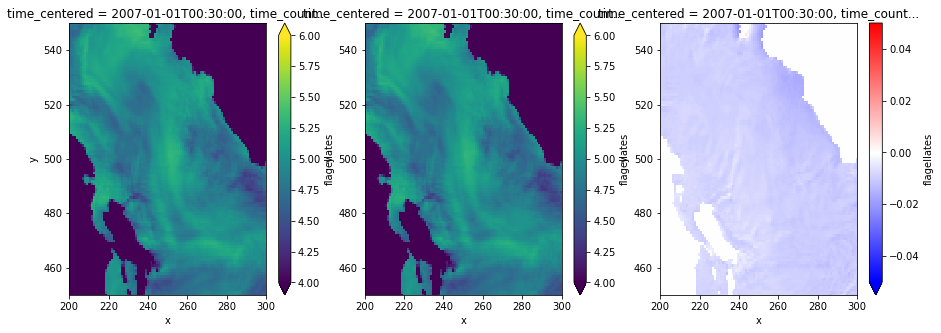

In [27]:
vmax = 6
vmin = 4
dv = 0.05
it = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_start.flagellates[it, 0:20]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_start.flagellates[it, 0:20]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_start.flagellates[it, 0:20]).sum(axis=0) -
 (base_start.flagellates[it, 0:20]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

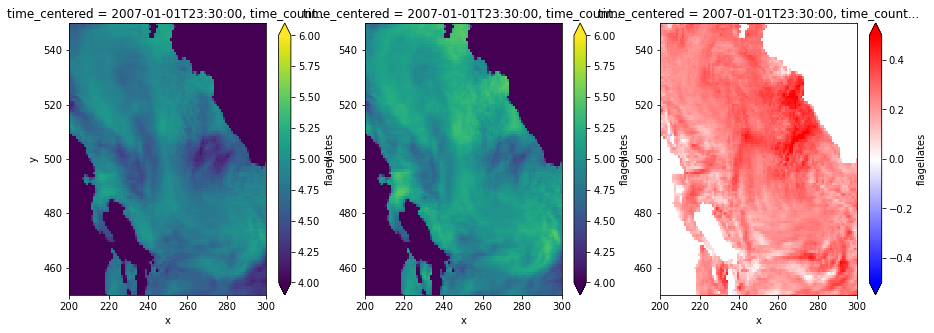

In [28]:
vmax = 6
vmin = 4
dv = 0.5
it = 23
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_start.flagellates[it, 0:20]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_start.flagellates[it, 0:20]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_start.flagellates[it, 0:20]).sum(axis=0) -
 (base_start.flagellates[it, 0:20]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

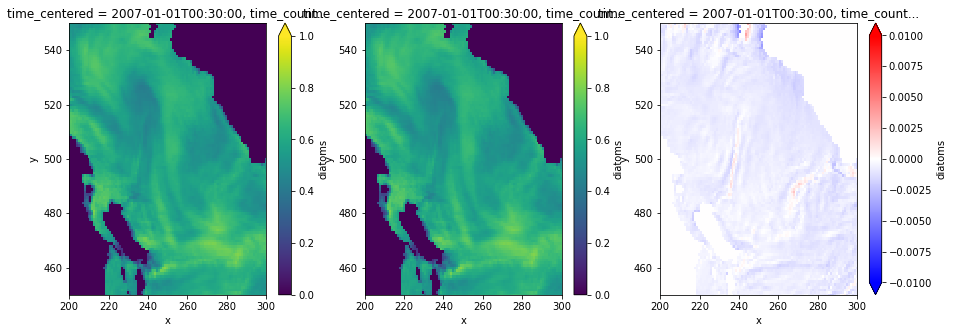

In [29]:
vmax = 1
vmin = 0
dv = 0.01
it = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_start.diatoms[it, 0:20]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_start.diatoms[it, 0:20]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_start.diatoms[it, 0:20]).sum(axis=0) -
 (base_start.diatoms[it, 0:20]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

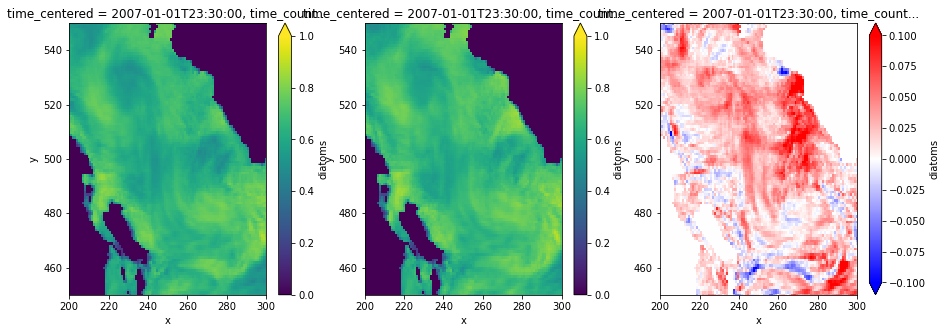

In [30]:
vmax = 1
vmin = 0
dv = 0.1
it = 23
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_start.diatoms[it, 0:20]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_start.diatoms[it, 0:20]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_start.diatoms[it, 0:20]).sum(axis=0) -
 (base_start.diatoms[it, 0:20]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

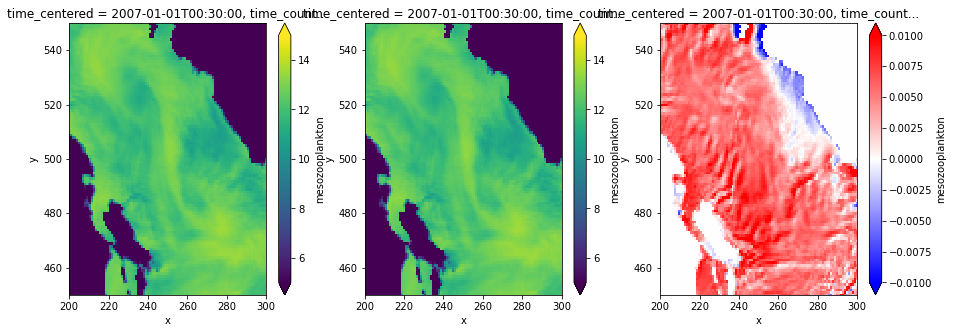

In [31]:
vmax = 15
vmin = 5
dv = 0.01
it = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_start.mesozooplankton[it, 0:20]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_start.mesozooplankton[it, 0:20]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_start.mesozooplankton[it, 0:20]).sum(axis=0) -
 (base_start.mesozooplankton[it, 0:20]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

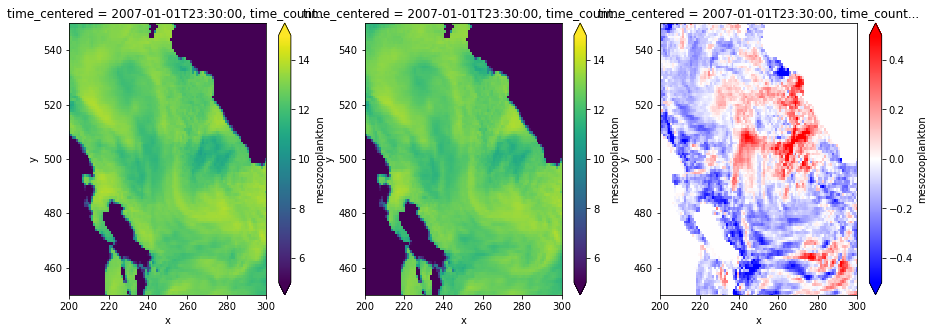

In [32]:
vmax = 15
vmin = 5
dv = 0.5
it = 23
bot = 20
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_start.mesozooplankton[it, 0:bot]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_start.mesozooplankton[it, 0:bot]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_start.mesozooplankton[it, 0:bot]).sum(axis=0) -
 (base_start.mesozooplankton[it, 0:bot]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

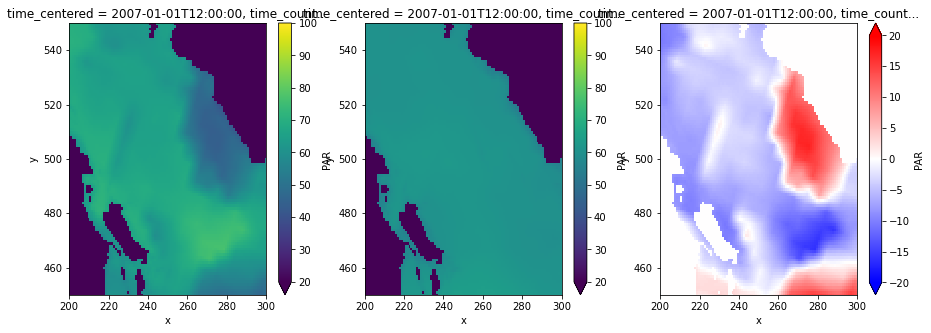

In [33]:
vmax = 100
vmin = 20
dv = 20
it = 0
bot = 20
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_carp.PAR[it, 0:bot]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_carp.PAR[it, 0:bot]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_carp.PAR[it, 0:bot]).sum(axis=0) -
 (base_carp.PAR[it, 0:bot]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
for ax in axs:
    ax.set_ylim((SoG_center[0], SoG_center[1]))
    ax.set_xlim((SoG_center[2], SoG_center[3]))

<xarray.DataArray 'PAR' ()>
array(18.82509422)
Coordinates:
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2007-01-01T12:00:00
<xarray.DataArray 'PAR' ()>
array(16.92728424)
Coordinates:
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2007-01-01T12:00:00


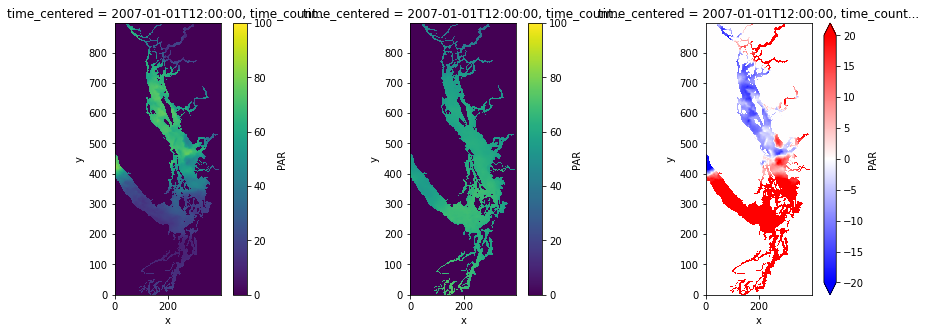

In [34]:
vmax = 100
vmin = 0
dv = 20
it = 0
bot = 20
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_carp.PAR[it, 0:bot]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_carp.PAR[it, 0:bot]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_carp.PAR[it, 0:bot]).sum(axis=0) -
 (base_carp.PAR[it, 0:bot]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
print (base_carp.PAR[it].max())
print (reconX_carp.PAR[it].max())
for ax in axs:
    viz_tools.set_aspect(ax)

In [35]:
base_start.close()
reconX_start.close()

In [36]:
day = '07'
tdir = '06jan07'
run = '20070106_20070110'
base_carp = xr.open_dataset(f'/data/sallen/results/MEOPAR/202111/base_32/01jan07/SalishSea_1d_20070101_20070131_carp_T_200701{day}-200701{day}.nc')
reconX_carp = xr.open_dataset(f'/data/sallen/results/MEOPAR/202111/reconX/{tdir}/SalishSea_1d_{run}_carp_T_200701{day}-200701{day}.nc')


FileNotFoundError: [Errno 2] No such file or directory: b'/data/sallen/results/MEOPAR/202111/reconX/06jan07/SalishSea_1d_20070106_20070110_carp_T_20070107-20070107.nc'

In [ ]:
vmax = 100
vmin = 0
dv = 20
it = 0
bot = 20
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
(base_carp.PAR[it, 0:bot]).sum(axis=0).plot(ax=axs[0], vmax=vmax, vmin=vmin)
(reconX_carp.PAR[it, 0:bot]).sum(axis=0).plot(ax=axs[1], vmax=vmax, vmin=vmin)
((reconX_carp.PAR[it, 0:bot]).sum(axis=0) -
 (base_carp.PAR[it, 0:bot]).sum(axis=0)).plot(ax=axs[2], vmin=-dv, vmax=dv, cmap='bwr');
print (base_carp.PAR[it].max())
print (reconX_carp.PAR[it].max())
for ax in axs:
    viz_tools.set_aspect(ax)